In [1]:
#default_exp fully_connected_network_02

In [2]:
#export
from ModernArchitecuturesFromScratch.basic_operations_01 import *

# Data Loading

In [3]:
#export
def normalize(datasets, mean=None, std=None):
    if mean is None: mean = datasets.mean()
    if std is None: std = datasets.std()
        
    return (datasets - mean) / std

def get_mnist():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    
    xt,yt,xv,yv = map(tensor, (x_train, y_train, x_valid, y_valid))
    return normalize(xt).float(), yt.float(), normalize(xv, xt.mean(), xt.std()).float(), yv.float()

In [4]:
xt,yt,xv,yv = get_mnist()

In [5]:
n_out = (yt.max()+1).item()
n_in = (xt[0].shape)[0]

In [6]:
#export 
def test_near_zero(data, tol=1e-3): assert data.abs() < tol; print(f'Near zero: {data}')

In [7]:
test_near_zero(xt.mean())

Near zero: 0.00012300178059376776


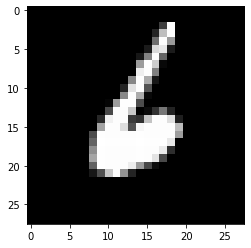

In [8]:
show_im(xt)

# Helper Functions

In [9]:
#export
def get_stats(data):
    print (f'Mean: {data.mean()}')
    print (f'Std: {data.std()}')

In [10]:
#export

#Kaiming initialization with fan_in
def get_weight(in_d, out_d, final):
    if not final: return torch.randn(in_d, out_d) * math.sqrt(2. / in_d)
    else: return torch.randn(in_d, out_d) / math.sqrt(in_d)
    
def linear(x, w, b): return x @ w + b

# Forward Pass

In [11]:
#export
def relu(x): return x.clamp_min(0.) - 0.5

def lin_rel(x, w, b): return relu(linear(x, w, b))

def softmax(x): return torch.exp(x) / torch.sum(torch.exp(x.unsqueeze(-1)), dim=1)

In [12]:
n_in = 28**2
n_out = 10

In [13]:
w1 = get_weight(n_in, 50, True)
w2 = get_weight(50, n_out, False)
b1 = torch.zeros(50)
b2 = torch.zeros(n_out)

In [14]:
def forward_pass(xb):
    xb = lin_rel(xb, w1, b1)
    xb = linear(xb, w2, b2)
    return xb

In [15]:
result = forward_pass(xt)

In [16]:
get_stats(result)

Mean: 0.08484654873609543
Std: 0.7059754729270935


# Loss

In [17]:
#export
def mse_loss(xb, yb): return (xb.squeeze(-1) - yb).pow(2).mean()

In [18]:
eps = 1e-9
def cross_entropy(xb, targ): return -( (xb + eps).log()[range(targ.shape[0]), targ.long()].mean() )

# Backwards Pass

In [19]:
def mse_grad(inp, targ):
    inp.g = 2. * (inp.squeeze(-1) - targ).unsqueeze(-1) / inp.shape[0]

In [20]:
def rel_grad(inp, out):
    inp.g = out.g * (inp > 0).float()

In [21]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t()
    w.g = (inp.unsqueeze(-1) * out.g.unsqueeze(1)).sum(0)
    b.g = out.g.sum(0)

In [22]:
def softmax_cross_grad(inp, targ):
    targ = torch.nn.functional.one_hot(targ.to(torch.int64), 10)
    inp_s = softmax(inp)
    inp.g = ( inp_s - targ ) / targ.shape[0]

In [23]:
def full_pass(xb, targ):
    l1 = linear(xb, w1, b1)
    l1_r = relu(l1)
    l2 = linear(l1_r, w2, b2)
    
    soft = softmax(l2)
    
    loss = cross_entropy(soft, targ)
    
    softmax_cross_grad(l2, targ)
    lin_grad(l1_r, l2, w2, b2)
    rel_grad(l1, l1_r)
    lin_grad(xb, l1, w1, b1)
    
    return loss

In [24]:
full_pass(xt, yt)

tensor(2.4088)

# Testing vs Pytorch Gradient

In [25]:
w1g = w1.g.clone()
w2g = w2.g.clone()
b1g = b1.g.clone()
b2g = b2.g.clone()
ig  = xt.g.clone()

In [26]:
xt2 = xt.clone().requires_grad_(True)
w12 = w1.clone().requires_grad_(True)
w22 = w2.clone().requires_grad_(True)
b12 = b1.clone().requires_grad_(True)
b22 = b2.clone().requires_grad_(True)

In [27]:
def auto_full_pass(xb, targ):
    l1 = linear(xb, w12, b12)
    l1_r = relu(l1)
    l2 = linear(l1_r, w22, b22)
    soft = softmax(l2)
    
    loss = cross_entropy(soft, targ)
    
    return loss

In [28]:
loss = auto_full_pass(xt2, yt)

In [29]:
loss.backward()

In [30]:
test_near(w22.grad, w2g)
test_near(b22.grad, b2g)
test_near(w12.grad, w1g)
test_near(b12.grad, b1g)
test_near(xt2.grad, ig )

good
good
good
good
good


# Refactoring

In [31]:
#export

class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception("Not Implemented")
        
    def backward(self): self.bwd(self.out, *self.args)

In [32]:
#export
class Linear(Module):
    def __init__(self, in_d, out_d, final): 
        self.w, self.b = get_weight(in_d, out_d, final), torch.zeros(out_d)

    def forward(self, xb): return xb @ self.w + self.b

    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [33]:
#export
class ReLU(Module):
    def forward(self, x): return x.clamp_min_(0.)-0.5
    
    def bwd(self, out, inp): 
        inp.g = (inp>0).float() * out.g

In [34]:
#export
class CrossSoft(Module):
    def forward(self, inp, targ):
        softed = self.soft_forward(inp)
        return self.cross_loss(softed, targ)
    
    def soft_forward(self, x): return torch.exp(x) / torch.sum(torch.exp(x.unsqueeze(-1)), dim=1)
        
    def cross_loss(self, xb, targ): return -( (xb + eps).log()[range(targ.shape[0]), targ.long()].mean() )
    
    def bwd(self, loss, inp, targ):
        targ = torch.nn.functional.one_hot(targ.to(torch.int64), 10)
        inp_s = softmax(inp)
        inp.g = ( inp_s - targ ) / targ.shape[0]

In [35]:
#export
class Model():
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

    def backward(self):
        for l in reversed(self.layers): l.backward()

In [36]:
layers = [Linear(784,50,True), ReLU(), Linear(50,10, False)]
loss_func = CrossSoft()
model = Model(layers)
loss = loss_func(model(xt),yt)

In [37]:
loss_func.backward()
model.backward()

In [38]:
w1g = model.layers[0].w.g.clone()
w2g = model.layers[2].w.g.clone()
b1g = model.layers[0].b.g.clone()
b2g = model.layers[2].b.g.clone()
ig  = xt.g.clone()

In [39]:
xt = xt.clone().requires_grad_(True)
model.layers[0].w = model.layers[0].w.clone().requires_grad_(True)
model.layers[0].b = model.layers[0].b.clone().requires_grad_(True)
model.layers[2].w = model.layers[2].w.clone().requires_grad_(True)
model.layers[2].b = model.layers[2].b.clone().requires_grad_(True)

In [40]:
%time loss = loss_func(model(xt), yt)

CPU times: user 209 ms, sys: 24.6 ms, total: 233 ms
Wall time: 58 ms


In [41]:
%time loss.backward()

CPU times: user 823 ms, sys: 48.8 ms, total: 872 ms
Wall time: 127 ms


In [42]:
test_near(w2g, model.layers[2].w.grad)
test_near(b2g, model.layers[2].b.grad)
test_near(w1g, model.layers[0].w.grad)
test_near(b1g, model.layers[0].b.grad)
test_near(ig, xt.grad)

good
good
good
good
good
